
Hi everyone,

This is my first Kaggle and ML problem. I am writing this with the intent of sharing my journey and attempts to my first ML Problem.This solution scored 0.78708 on Kaggle. Some tuning of the model yielded my highest score of 0.79904 but unfortunately I didn't keep track of that. :|
<img src="score.png" alt="drawing" width="800" hieght="200"/>
Any suggestions to improve the method are welcome. 

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

data = train.copy()

Exploratory Data Analysis
==
Train Set Overview

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Fam            891 non-null int64
famcat         891 non-null object
fare_class     891 non-null category
name_len       891 non-null int64
title          891 non-null object
tcat           891 non-null object
tlen           891 non-null int64
age_class      891 non-null category
newage         891 non-null float64
cabincat       891 non-null object
dtypes: category(2), float64(3), int64(8), object(9)
memory usage: 141.2+ KB


In [62]:
# data.head()

Individual Variables Overview
==


### 1.Pclass and Sex

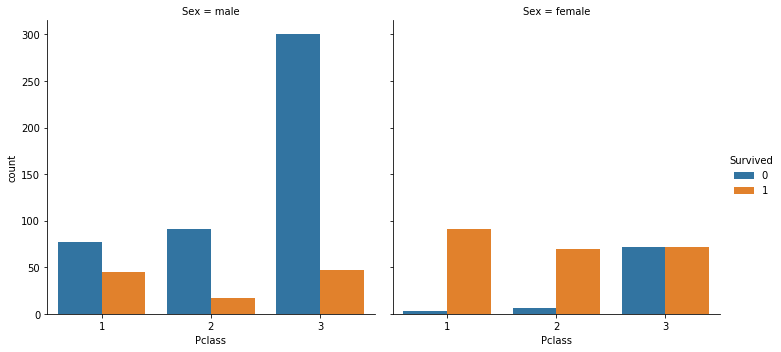

In [63]:
sns.catplot(x='Pclass',col='Sex', hue='Survived', data=data, kind='count')

Females have higher chance of Survival.<br>
Pclass 1 has highest chance of Survival

<h3>2. Parch</h3>

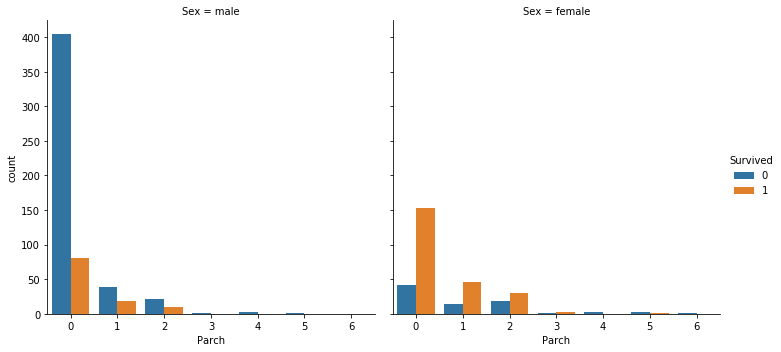

In [64]:
sns.catplot(x='Parch',col='Sex', hue='Survived', data=data, kind='count')

Lower Parch has better chances of Survival.as they had to take care of only themselves while family people need to look after each other

<h3>3. SibSp</h3>

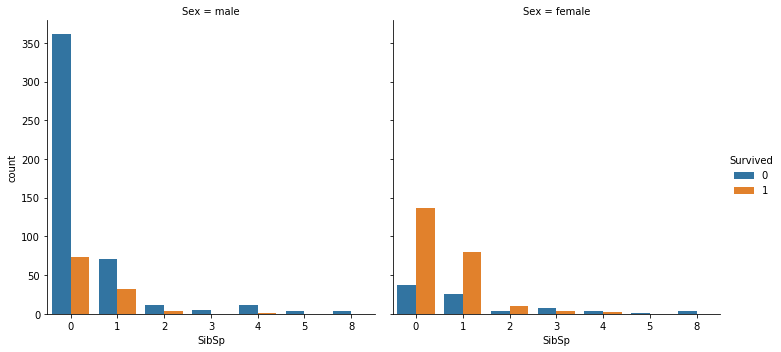

In [65]:
sns.catplot(x='SibSp',col='Sex', hue='Survived', data=data, kind='count')

Lower SibSp have better chances of Survival just like Parch. But any classifier can get skewed because of large number of classes. So lets combine Parch and SibSp to Family and classify families,

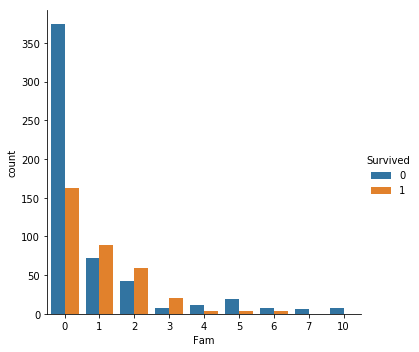

In [149]:
data['Fam'] = data['SibSp'] + data['Parch']
sns.catplot(x='Fam', hue='Survived',kind='count', data=data)

In [150]:
data['famcat'] = data['Fam'].apply(lambda x: 'none' if x==0 else ( 'small' if (x==1) or (x==2) or (x==3) else 'large'))

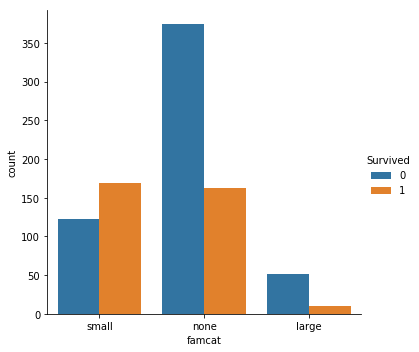

In [68]:
sns.catplot(x='famcat', hue='Survived',kind='count', data=data)

### 4. Embarked

In [151]:
#Embarked hardly have any na. Fill with mode
data['Embarked'].fillna('S', inplace = True)

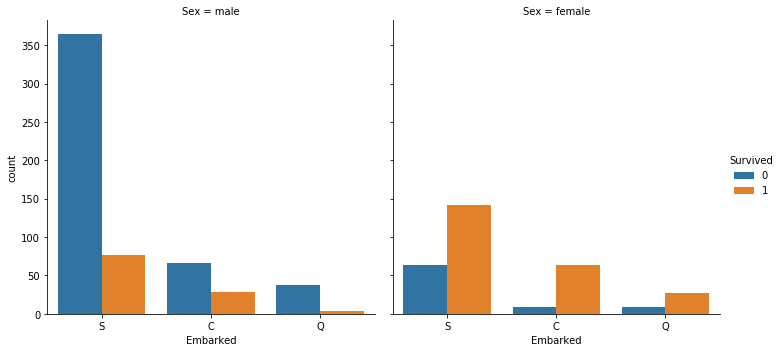

In [70]:
sns.catplot(x='Embarked', hue='Survived', col='Sex', kind='count', data=data)

For males C seems to be the best while for females it was S.

### 5. Fare

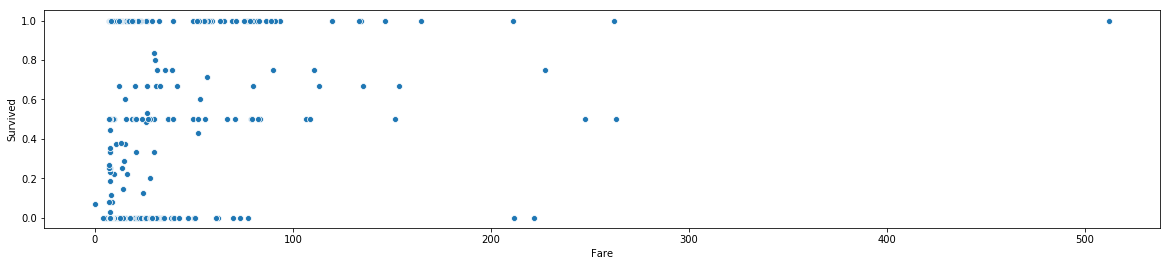

In [71]:
b = data[['Fare', 'Survived']].groupby(['Fare']).mean().sort_values(by='Survived')
fig = plt.subplots(1,1,figsize=(20,4))
sns.relplot(x=b.index, y='Survived', data=b, ax=fig[1])
plt.close(2)

In [72]:
c = pd.qcut(data['Fare'], 4)
data['fare_class'] = c

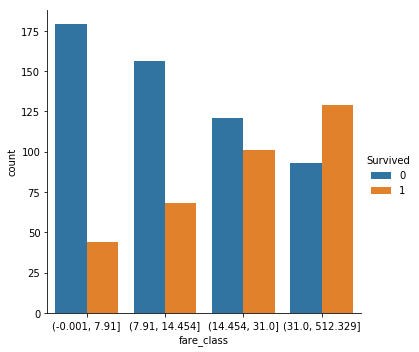

In [73]:
sns.catplot(x='fare_class', hue='Survived', data=data, kind='count')

clearly higher paying class had better chance of Survival

### 6. Name
Checking an assumption that important people had longer names and must have higher chances of survival 

In [152]:
data['name_len'] = data['Name'].apply(lambda x: len(x))
print(data['Survived'].groupby(pd.qcut(data['name_len'],5)).mean(),pd.qcut(data['name_len'],5).value_counts())

name_len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64 (11.999, 19.0]    204
(23.0, 27.0]      197
(32.0, 82.0]      169
(27.0, 32.0]      165
(19.0, 23.0]      156
Name: name_len, dtype: int64


Classify people based on their titles

In [153]:
data['title'] = data['Name'].apply( lambda x: str(x).split(',')[1].split()[0])

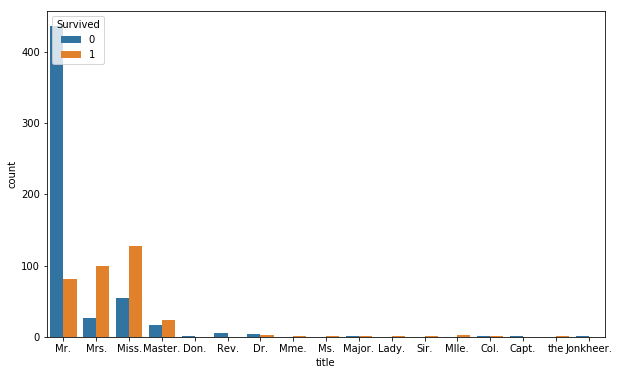

In [154]:
fig = plt.subplots(1,1,figsize=(10,6))
sns.catplot(x='title',hue='Survived',kind='count',data=data, ax=fig[1])
plt.close(2)

In [77]:
b = data[['title', 'Survived']].groupby(['title']).mean().sort_values(by='Survived')
b['title'] = b.index
b

,Survived,title
title,,
Capt.,0.000000,Capt.
Don.,0.000000,Don.
Jonkheer.,0.000000,Jonkheer.
Rev.,0.000000,Rev.
Mr.,0.156673,Mr.
Dr.,0.428571,Dr.
Col.,0.500000,Col.
Major.,0.500000,Major.
Master.,0.575000,Master.


Too many classes can skew any classifier. So reducing the number of classes

In [155]:
data['title'] = data['title'].apply(lambda x: x if x in ['Mr.', 'Mrs.', 'Miss.', 'Master.'] else ('live' if x in ['the','Mlle','Lady','Ms.','Sir.','Mme.'] else 'rare'))

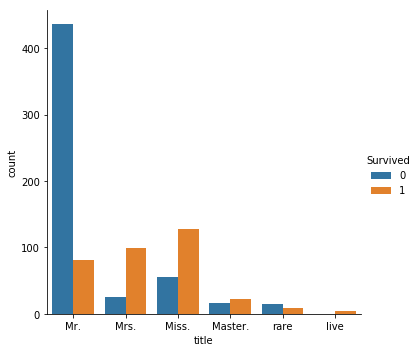

In [161]:
sns.catplot(x='title',hue='Survived',kind='count',data=data,)

### 7. Ticket
As we do not have much information on cabin we may try to retrieve it from ticket. End of every ticket is just a number. It must be the prefix which should matter

In [136]:
data['Ticket'].head(70)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
20              239865
21              248698
22              330923
23              113788
24              349909
25              347077
26                2631
27               19950
28              330959
29              349216
            ...       
40                7546
41               11668
42              349253
43       SC/Paris 2123
44              330958
45     S.C./A.4. 23567
46              370371
47               14311
48                2662
49              349237
50             3101295
51          A/4. 39886
52         

In [156]:
data['Ticket'] = data['Ticket'].apply( lambda x: x.replace('.', ''))

In [157]:
data['Ticket'] = data['Ticket'].apply( lambda x: x.replace('/', ''))

In [158]:
data['tcat'] = data['Ticket'].apply( lambda x: 'NUM' if x.split()[0].isdigit() else x.split()[0])

In [163]:
a  = data[['tcat', 'Survived']].groupby(['tcat']).mean()
a['tcat'] = a.index
b = data[['tcat', 'Survived']].groupby(['tcat']).std()
a['std'] = b['Survived']
a.sort_values(by='Survived')

,Survived,tcat,std
tcat,,,
X,0.000000,X,0.000000
A5,0.095238,A5,0.300793
WC,0.100000,WC,0.316228
SOTONOQ,0.133333,SOTONOQ,0.351866
SOC,0.166667,SOC,0.408248
LINE,0.250000,LINE,0.500000
WEP,0.333333,WEP,0.577350
CA,0.341463,CA,0.480091
NUM,0.384266,NUM,0.486790


In [162]:
data['tcat'] = data['tcat'].apply( lambda x: 'X' if x in ['A4', 'SP', 'SOTONO2', 'SOPP', 'SOP', 'SCOW', 'Fa', 'SCA4', 'FC', 'AS', 'CASOTON'] else x)

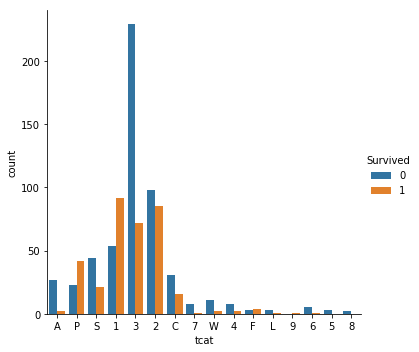

In [84]:
sns.catplot(x='tcat', hue='Survived', data=data, kind='count')

There seems to be some sort of relation between Ticket Category and Survival

### 8. Age
Some data for age is missing but lets see any relationship exists for age and survival

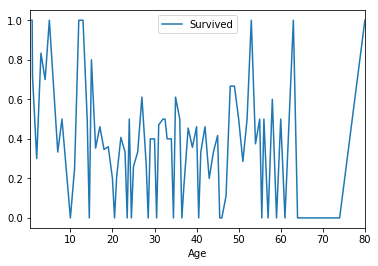

In [86]:
a = data[['Age','Survived']].groupby('Age').mean()
a['Age']=a.index
a.plot(kind='line', x='Age', y='Survived')

In [125]:
data['age_class'] = pd.qcut(data['Age'],5)

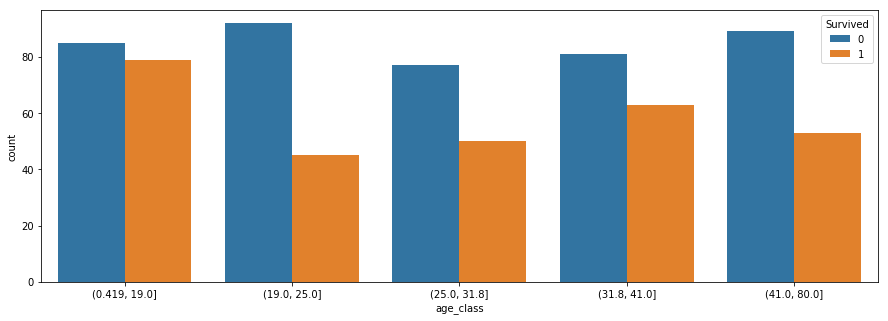

In [126]:
fig = plt.subplots(1,1,figsize=(15,5))
sns.catplot(x='age_class', hue='Survived', kind='count', data=data,ax=fig[1])
plt.close(2)

Younger class has very good chances for survival (almost 50%) then older classes. But we need to impute ages in order to use it.

In [90]:
# sns.pairplot(data)

No clear relationship between Age and other numerical columns

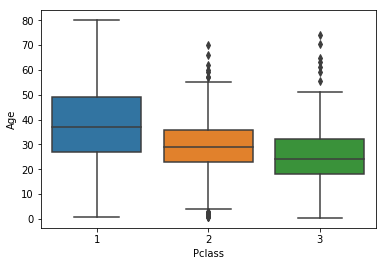

In [91]:
sns.boxplot(y='Age',x='Pclass', data=data)

Decrease in average age with increase in class number

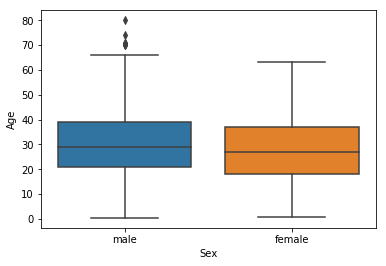

In [120]:
sns.boxplot(y='Age',x='Sex', data=data)

We can include Sex as deciding factor

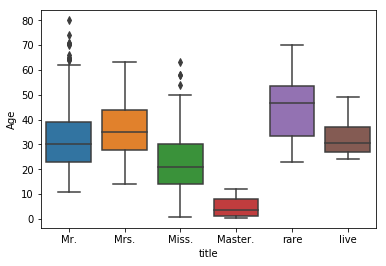

In [92]:
sns.boxplot(y='Age',x='title', data=data)

A relation exist between age and title

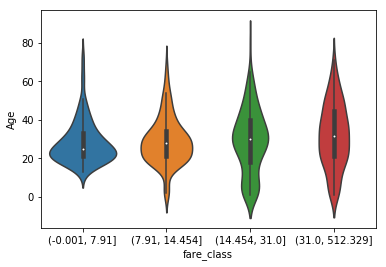

In [93]:
sns.violinplot(y='Age',x='fare_class', data=data)

Distribution almost same for all fare classes and age. No clear relation

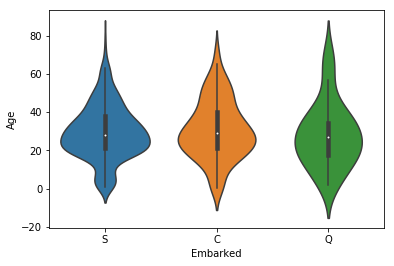

In [94]:
sns.violinplot(y='Age',x='Embarked', data=data)

Distribution almost same for all Embarked classes and age. No clear relation

I aim to fill na values in Age by grouping data by title and Pclass and using mean age of these groups.

In [121]:
a = data.groupby(['Pclass','title','Sex'])

In [122]:
b = a['Age'].transform('mean')

In [123]:
b.isna().sum()

0

In [124]:
b = data['Age'].fillna(b)
data['newage'] =  b.copy()
data['newage'].isna().sum()

0

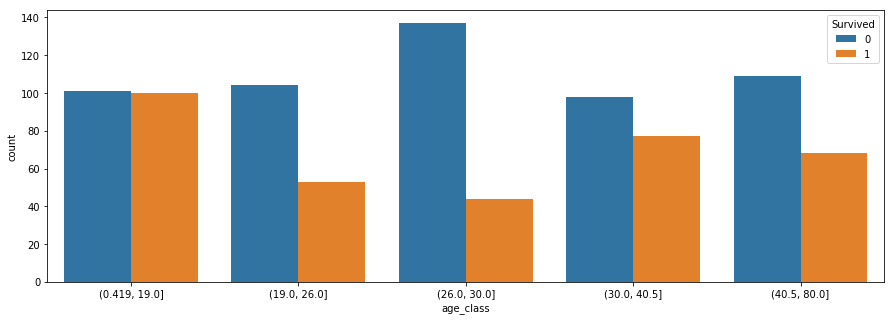

In [127]:
data['age_class'] = pd.qcut(data['newage'],5)
fig = plt.subplots(1,1,figsize=(15,5))
sns.catplot(x='age_class', hue='Survived', kind='count', data=data,ax=fig[1])
plt.close(2)

pd.qcut() on 'newage' produced almost the same classes as 'Age' which suggest our imputing method was good.

## 9. Cabin

In [118]:
data['cabincat'] = data['Cabin'].apply(lambda x: str(x)[0])

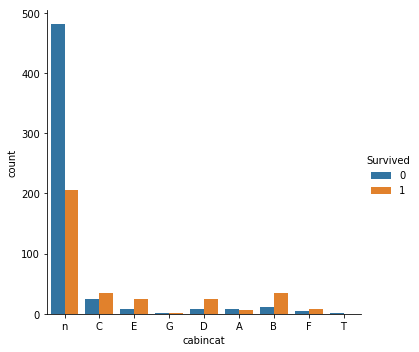

In [119]:
sns.catplot(x='cabincat', hue='Survived', data = data, kind='count')